# 2 Neural Network Classification with PyTorch

Reference: Daniel Bourke's GitHub [02_pytorch_classification.ipynb](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb)

Book version of the book: [02_pytorch_classification](https://www.learnpytorch.io/02_pytorch_classification/)

Basic destinction
- **Regression**: Predicting numbers
- **Classfication**: Predicting things
  - Binary  classification: e.g. [spam, not spam], [dog, cat]
  - Multi-class classification: e.g. [dog, car, chicken]
  - Multi-label classification: More than one label per class

![](screenshots/1_Module_contents.png)

## 1 Classification inputs and outputs

We will start with simple-label multi-class image classification.

**Inputs**

Each image is characterized by a 3D matrix (width, height, color), usually encoded as

``` 
shape = [batch_size, color_channels, width, height]
shape = [32, 3, 224, 224]
```

(where `batch_size = 32`, or other multiples of 8 are a very commonly used values)

**Computation layer**

PyTorch-based neural network

**Outputs**

A tensor of the probabilities of an input corresponding to any of the designated classes.
One then finds the maximum probability and computes the most likely label

### Architecture

### Hyperparameters

1. Input layer shape
2. Hidden layer definition
   1. Neurons per hidden layer
   2. Output layer shape
   3. Hidden layer activation function (e.g. ReLU)
3. Output layer activation (e.g. sigmoid)
4. Loss function
5. Optimizer


### Summary of how each is defined

![](screenshots/2_Summary_Netwrok_Architecture.png)

#### Classification dataset

X.shape = (1000, 2)
y.shape = (1000,)


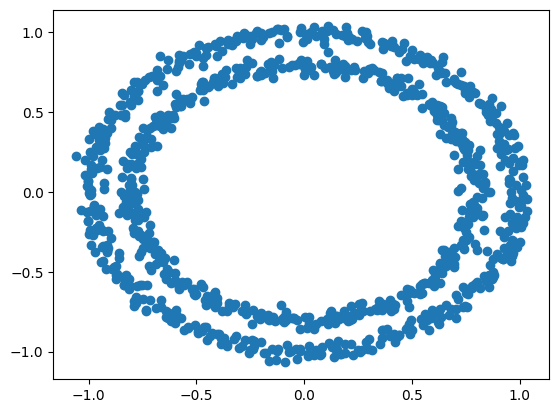

In [98]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000                                                # number of samples   

X, y = make_circles(n_samples, noise=0.03, random_state=42)     # creates two circles

plt.scatter(X[:,0],X[:,1])

print(f"X.shape = {X.shape}")                                   # first col of C stores x, second y coordinates
print(f"y.shape = {y.shape}")                                   # y contains the labels (whether they belong to circle 0 or 1)

In [99]:
import pandas as pd

# visualizing with a pandas dataframe
circles = pd.DataFrame({"X1": X[:,0],
                        "X2":X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


(1000, 2)

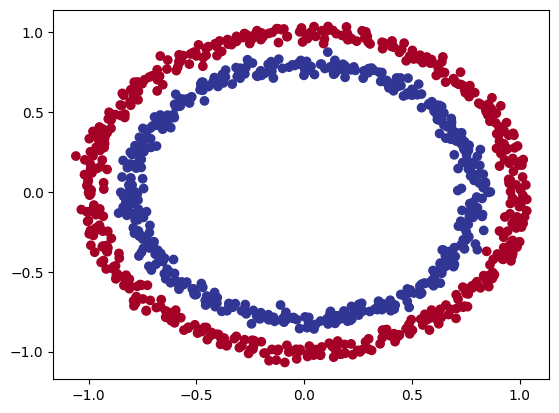

In [100]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap="RdYlBu")

X.shape


**Note**: This kind of simple dataset is often referred to a toy dataset. Small and simple to use, but enough to test and learn.

Checkout scikit learn documentation to look for more toy datasets

### Validate input and output shape requirements

In [101]:
print(f"X.shape = {X.shape}")       # the number of cols in X corresponds to the number of features that characterize our data
print(f"y.shape = {y.shape}")

X.shape = (1000, 2)
y.shape = (1000,)


### Convert the data into tensors

In [102]:
# turn data into tensors

import torch
torch.__version__

'2.1.0+cpu'

In [103]:

print(f"type(X) = {type(X)}, type(y) = {type(y)}")  # numpy
X = torch.from_numpy(X).type(torch.float)           # convert to torch floats
y = torch.from_numpy(y).type(torch.float)
print(f"type(X) = {type(X)}, type(y) = {type(y)}")  # torch tensor

type(X) = <class 'numpy.ndarray'>, type(y) = <class 'numpy.ndarray'>
type(X) = <class 'torch.Tensor'>, type(y) = <class 'torch.Tensor'>


In [104]:
# split data into training and test sets
# alternative: from torch.utils.data import TensorDataset, random_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,               # data and labels
                                                    test_size=0.2,      # percentage assigned to test dataset
                                                    random_state=42)    # set manual random seed

len(X_train), len(y_train), len(X_test), len(y_test)                                               # 80-20 split

(800, 800, 200, 200)

## 2 Building a model

Building a model to classify between two circles (here colored as blue or red)

Doing so requires (same as done in the last module):
1. Setting up device agnostic code
2. Creating the model
3. Defining the loss function and optimizer
4. Creating the training and test loop
5. Making prediction

In [105]:
from torch import nn

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"             # setup device

def send_to_device(mats):                                           # method to send datasets to device
    return [mat.to(device) for mat in mats]

default_dataset = [X_train, y_train, X_test, y_test]                # default training and testing dataset

X_train, y_train, X_test, y_test = send_to_device(default_dataset)  # send default dataset to device

### Creating a multilayer NN model

1. Subclass nn.Module
2. Create two linear layers compatible with the defined data shapes
3. Define the forward method
4. Instantiate the model class and send it to target device

In [106]:
# 1 constructing the module

class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)                               # initialize parent class
        
        # 2 creating two layers compatible with the data shape
        self.layer_1 = nn.Linear(in_features=2,                         # number of input features
                                 out_features=5)                        # number of output features (arbitrary, usually multiple of 8)
        self.layer_2 = nn.Linear(in_features=self.layer_1.out_features, # inputs of the hidden layer must match output of previous
                                 out_features=1)                        # number of output features (single label y)
        
    # 3 forward pass method
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """ method that implements the forward pass """

        return self.layer_2(self.layer_1(x))                            # return nested layer pass

# 4 instantiate CircleModelV0
cm0 = CircleModelV0().to(device)                                        # instantiate and send to device
next(cm0.parameters()).device                                           # print current device

device(type='cpu')

### Replicating the previous model using a faster notation

In [107]:
cm0 = nn.Sequential(                                                    # fully connected network
    nn.Linear(in_features=2, out_features=5),                           # first
    nn.Linear(in_features=5, out_features=1)                            # second layer
).to(device)                                                            # send to device

### Combined notations

In [108]:
# one can also combine both notations

class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)                               # initialize parent class
        
        # 2 creating two layers compatible with the data shape
        self.linear_layers = nn.Sequential(                             # fully connected network
                nn.Linear(in_features=2, out_features=5),               # first
                nn.Linear(in_features=5, out_features=1)                # second layer
                ).to(device)                                            # send to device
        
    # 3 forward pass method
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """ method that implements the forward pass """

        return self.linear_layers(x)                                    # return sequential network pass

# 4 instantiate CircleModelV1
cm1 = CircleModelV1().to(device)                                        # instantiate and send to device
next(cm1.parameters()).device                                           # print current device

device(type='cpu')

In [109]:
cm0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

### Making predictions

In [110]:
# Making predictions

with torch.inference_mode():
    untrained_preds = cm0(X_test)                                           # make prediction (X_test is already on target device)
    print(f"[predictions] len: {len(untrained_preds)}, shape: {untrained_preds.shape}")
    print(f"[labels] len: {len(y_test)}, shape: {y_test.shape}")
    print(f"First 10 labels: {untrained_preds[:10]}")
    print(f"First 10 labels: {y_test[:10]}")

[predictions] len: 200, shape: torch.Size([200, 1])
[labels] len: 200, shape: torch.Size([200])
First 10 labels: tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup loss function and optimizer

Which loss function or optimizers to use?

**Loss functions**
- Regression: MAE(L) or MSE (linear and square error)
- Classification: **Binary Cross Entropy** (BCE) or **Categorical Cross Entropy** (CCE)

**Optimizers**
- Regression: SGD - Stochastic Gradient Descent 
- Classification: ADAM

**Notes:**
1. These are application-specific functions optimized to quantify the error associated with each type of task
2. The *logits* layer is the layer that feeds in to softmax or other such normalization. The output of softmax are the probabilities for the classification task and its input is the logits layer. This concept will become clearer later on

In [111]:
#loss_fn = nn.BCELoss()                                          # requires inputs to have gone through the sigmoid prior to its use
loss_fn = nn.BCEWithLogitsLoss()                                # sigmoid activation function + BCE loss (numerically stable)

optimizer = torch.optim.SGD(params=cm0.parameters(),            # model parameters
                            lr = 0.1)                           # learning rate

# calculate the accuracy - success percentage
def acc_fn(y:torch.Tensor, y_pred:torch.Tensor) -> torch.Tensor:
    """ method to calculate the model's prediction accuracy """

    # my way
    return torch.sum(y==y_pred)/len(y)*100                      # return success percentage
    
    # the way Daniel implements it:
    n_correct = torch.eq(y, y_pred).sum().item()                # funky torch notation to sum the number of equalities
    return n_correct/len(y_pred) * 100                          # return success percentage
    
acc_fn(y_test, untrained_preds)

tensor(0.)

## 3 Train the model

**Training loop**
 - Forward pass
 - Calculate the loss
 - Optimizer grad
 - Loss back-propagation
 - Optimizer step (gradient descent)

### 3.1 From Raw logits to pediction probabilities to prediction labels

The model outputs "raw" **logits**

We can convert them into p**rediction probabilities** by passing them through an activation function

The probabilities can then be converted from probailities to labels rounding or taking the `argmax()`

In [112]:
# View the first 5 outputs of the forwards pass on the test data

cm0.eval()
with torch.inference_mode():
    
    y_logits = cm0(X_test.to(device))[:5]   # direct model output

y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [113]:
# Converting the model logits into prediction probabilities by passing them through a sigmoid activation function

y_pred_probs = torch.sigmoid(y_logits)  # prediction probabilities
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In turn, the prediction probabilities can be converted into labels using a range-like rounding

In [114]:
# Find the prediction label by rounding the probabilities

y_pred_labels = torch.round(y_pred_probs)

In [115]:
torch.manual_seed(42)

if device == "cuda":
    torch.cuda.manual_seed(42)

epochs = 100                                                        # number of epochs

X_train, y_train, X_test, y_test = send_to_device(default_dataset)  # make it device-agnostic

for epoch in range(epochs):

    cm0.train()                                                     # set to training mode
    y_logits = cm0(X_train).squeeze()                               # do the forward pass

    y_pred = torch.round(torch.sigmoid(y_logits))                   # compute prediction labels as above

    # since the loss function expects logits (BCE with logits), that is what we need to pass
    loss = loss_fn(y_logits, y_train)                               # calculate the loss
    acc = acc_fn(y=y_train, y_pred=y_pred)                          # calculate the accuracy

    optimizer.zero_grad()                                           # initialize gradients

    loss.backward()                                                 # backward propagation (calculate gradients)
    
    optimizer.step()                                                # gradient descent

    # testing 

    cm0.eval()
    with torch.inference_mode():

        # forward pass
        test_logits = cm0(X_test).squeeze()                         # test logits
        test_pred = torch.round(torch.sigmoid(test_logits))         # test predictions

        test_loss = loss_fn(test_logits, y_test)                    # test loss
        test_acc = acc_fn(y=y_test, y_pred=test_pred)               # test accuracy

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, loss: {loss:.5f}, acc: {acc:.2f}, test_loss: {test_loss:.5f}, test_acc: {test_acc:.2f}")

Epoch: 0, loss: 0.69796, acc: 51.88, test_loss: 0.69440, test_acc: 58.00
Epoch: 10, loss: 0.69590, acc: 51.25, test_loss: 0.69305, test_acc: 53.00
Epoch: 20, loss: 0.69490, acc: 51.62, test_loss: 0.69254, test_acc: 49.50
Epoch: 30, loss: 0.69435, acc: 51.12, test_loss: 0.69236, test_acc: 49.50
Epoch: 40, loss: 0.69401, acc: 50.88, test_loss: 0.69232, test_acc: 51.00
Epoch: 50, loss: 0.69378, acc: 50.25, test_loss: 0.69234, test_acc: 50.00
Epoch: 60, loss: 0.69362, acc: 50.00, test_loss: 0.69239, test_acc: 51.50
Epoch: 70, loss: 0.69351, acc: 50.25, test_loss: 0.69246, test_acc: 51.00
Epoch: 80, loss: 0.69342, acc: 49.88, test_loss: 0.69254, test_acc: 50.00
Epoch: 90, loss: 0.69336, acc: 49.88, test_loss: 0.69262, test_acc: 53.00


## 4. Visualizing predictions

The results above show that he mode is not learning.

To try to understand why, one can visualize the predictions using the `plot_decision_boundary()`

In [116]:
import requests
from pathlib import Path

# download helper functions from Learn PyTorch repo, if not already downloaded
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    # request helper functions from raw url
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


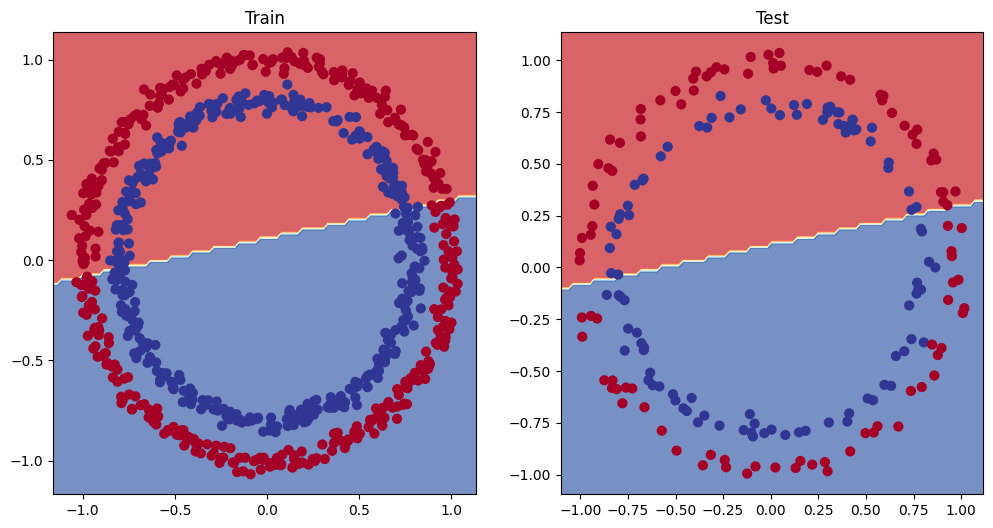

In [117]:
# plot decision boundary of the model

plt.figure(figsize=(12,6))                      # new figure for subplots

plt.subplot(1,2,1)                              # train subplot
plt.title("Train")                              # title it
plot_decision_boundary(cm0, X_train, y_train)   # plot boundary decision
plt.subplot(1,2,2)                              # test subplot
plt.title("Test")                               # title it
plot_decision_boundary(cm0, X_test, y_test)     # plot boundary decision

## 5. Improving a model (from a model perspective)

- Add more layers (higher chance of learning about patterns in the data)
- Add more hidden units (adding more neurons per hidden layer)
- Fit for longer (more epochs)
- Changing the activation functions (sigmoid, activation within the model)
- Changing the learning rate (learn faster - avoid vanishing gradients, prevent divergence - avoid gradient explosion, overcome local minima)
- Change the loss function (not for the moment)

These options are from a model's perspective, because they are all relative to the model's properties, no the data

![](./screenshots/3_Model_Development_chart.png)

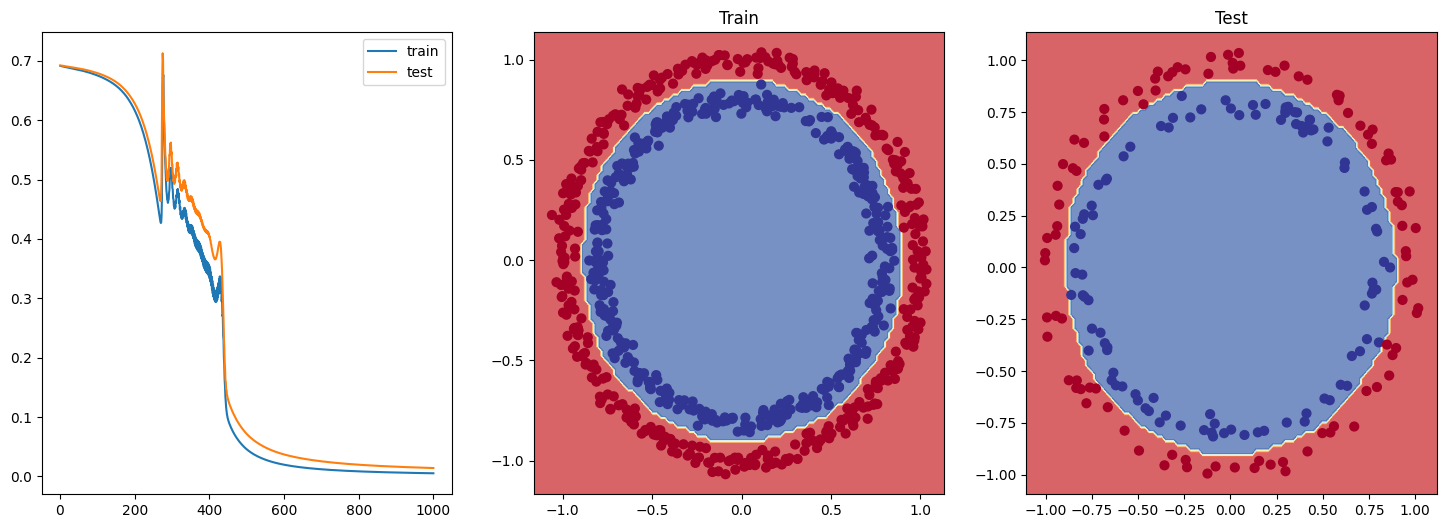

In [118]:
# Attempt to improve model by adding more layers and hidden units (before watching solution on next video)

import numpy as np

def evaluate_model(model, X_test, y_test, epoch, test_logits, step=100):
    # forward pass
    test_logits = model(X_test).squeeze()                               # test logits
    test_pred = torch.round(torch.sigmoid(test_logits))                 # test predictions

    test_loss = loss_fn(test_logits, y_test)                            # test loss
    test_acc = acc_fn(y=y_test, y_pred=test_pred)                       # test accuracy

    if step > 0 and epoch % step == 0:
        print(f"Epoch: {epoch}, loss: {loss:.5f}, acc: {acc:.2f}, test_loss: {test_loss:.5f}, test_acc: {test_acc:.2f}")
    
    return test_loss

# 1 define the mode
class CircleModelV2(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)                               # initialize parent class
        
        # 2 creating two layers compatible with the data shape
        self.linear_layers = nn.Sequential(                             # fully connected network
                nn.Linear(in_features=2, out_features=128),               # first hidden layer
                nn.ReLU(),                                              # rectified linear unit function
                nn.Linear(in_features=128, out_features=256),               # second hidden unit layer
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=128),               # second hidden unit layer
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=1)                # output layer
                ).to(device)                                            # send to device
        
    # 3 forward pass method
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """ method that implements the forward pass """

        return self.linear_layers(x)                                    # return sequential network pass

# 4 instantiate CircleModelV2
cm2 = CircleModelV2().to(device)                                        # instantiate and send to device
next(cm2.parameters()).device                                           # print current device

# setup loss function
loss_fn = nn.BCEWithLogitsLoss()                                        # sigmoid activation function + BCE loss (numerically stable)

optimizer = torch.optim.SGD(params=cm2.parameters(),                    # model parameters
                            lr = 0.1)                                   # learning rate

# training the model
torch.manual_seed(42)                                                   # manually set random seed

if device == "cuda":                                                    # device agnostic option
    torch.cuda.manual_seed(42)

epochs = 1000                                                            # number of epochs

X_train, y_train, X_test, y_test = send_to_device(default_dataset)      # make it device-agnostic

train_losses, test_losses = [], []

for epoch in range(epochs):

    cm2.train()                                                         # set to training mode
    y_logits = cm2(X_train).squeeze()                                   # do the forward pass
    y_pred = torch.round(torch.sigmoid(y_logits))                       # compute prediction labels as above
    loss = loss_fn(y_logits, y_train)                                   # calculate the loss
    acc = acc_fn(y=y_train, y_pred=y_pred)                              # calculate the accuracy

    optimizer.zero_grad()                                               # initialize gradients
    loss.backward()                                                     # backward propagation (calculate gradients)
    optimizer.step()                                                    # gradient descent

    # testing
    cm2.eval()                                                          # set to evaluation mode
    with torch.inference_mode():                                        # set Torch to inference mode
        test_loss = evaluate_model(cm2, X_test, y_test,
                                   epoch, test_logits, step=0)          # evaluate model's learning progress

    train_losses.append(float(loss))
    test_losses.append(float(test_loss))

# plot the decision boundary for the model
plt.figure(figsize=(18,6))                          # new figure for subplots
plt.subplot(1,3,1)                                  # learning subplot
plt.plot(np.arange(epochs)+1, np.array([train_losses, test_losses]).T, label=["train", "test"])
plt.legend()                                        # show legend
plt.subplot(1,3,2)                                  # train subplot
plt.title("Train")                                  # title it
plot_decision_boundary(cm2, X_train, y_train)       # plot boundary decision
plt.subplot(1,3,3)                                  # test subplot
plt.title("Test")                                   # title it
plot_decision_boundary(cm2, X_test, y_test)         # plot boundary decision

### Daniel's solution (from the videos)

Approach:
 - Adding more hidden units: 5 -> 10
 - Increasing the number of layers: 2-> 3
 - Increasing the number of epochs: 100 -> 100

In [119]:
# Daniel's solution (from the videos)

class CircleModelV3(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_3 = CircleModelV3().to(device)

# create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), 
                            lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# training and evaluation loop for model_3
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # training mode
    model_3.train()
    
    # forward pass
    y_logits = model_3.forward(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc =  acc_fn(y=y_train, y_pred=y_pred)

    # optimizer zero gradient
    optimizer.zero_grad()

    # back propagation
    loss.backward()

    # optimizer step
    optimizer.step()

    # evaluation mode
    model_3.eval()

    with torch.inference_mode():
        # forward pass of the test data
        test_logits = model_3.forward(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc =  acc_fn(y=y_test, y_pred=test_pred)

    # print results
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396 | Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 100 | Loss: 0.69305 | Accuracy: 50.38% | Test Loss: 0.69379 | Test Accuracy: 48.00%
Epoch: 200 | Loss: 0.69299 | Accuracy: 51.12% | Test Loss: 0.69437 | Test Accuracy: 46.00%
Epoch: 300 | Loss: 0.69298 | Accuracy: 51.62% | Test Loss: 0.69458 | Test Accuracy: 45.00%
Epoch: 400 | Loss: 0.69298 | Accuracy: 51.12% | Test Loss: 0.69465 | Test Accuracy: 46.00%
Epoch: 500 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69467 | Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69468 | Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69468 | Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69468 | Test Accuracy: 46.00%
Epoch: 900 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69468 | Test Accuracy: 46.00%


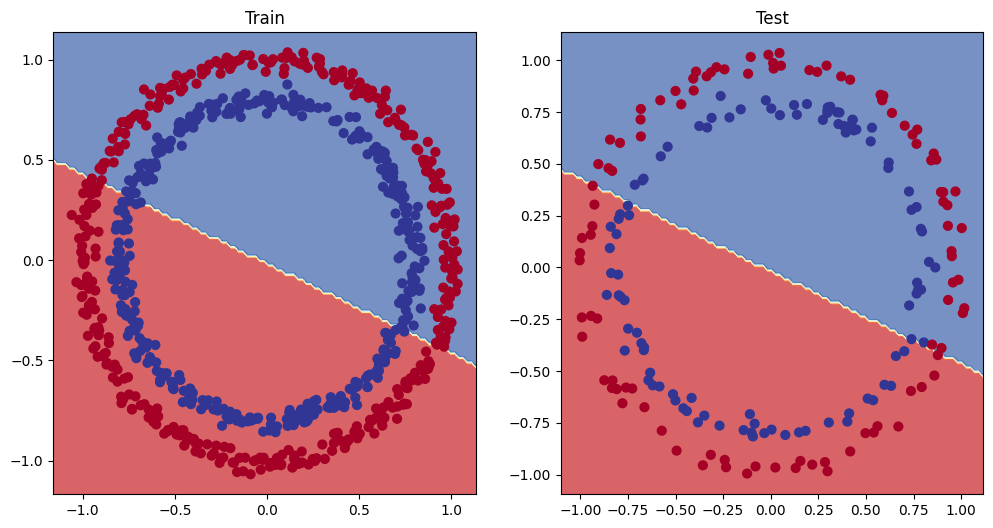

In [120]:
# plot the decision boundary for the model
plt.figure(figsize=(12,6))                          # new figure for subplots

plt.subplot(1,2,1)                                  # train subplot
plt.title("Train")                                  # title it
plot_decision_boundary(model_3, X_train, y_train)   # plot boundary decision
plt.subplot(1,2,2)                                  # test subplot
plt.title("Test")                                   # title it
plot_decision_boundary(model_3, X_test, y_test)     # plot boundary decision

### 5.1 Preparing the data to see if the model can fit a straight line

As expected, the linear models is simply not suited for fitting circular line.
But can it fit anything at all? Can it fit a linear dataset such as the one used in 01 PyTorch Fundaments?

In [121]:
# Create the data parameters
weight = 0.7
bias = 0.3
step = 0.01

# Make X and y using linear regression feature
X_regression = torch.arange(0, 1, step).unsqueeze(1)
y_regression = bias + weight*X_regression

print(f"Number of X samples: {len(X_regression)}")
print(f"Number of y samples: {len(y_regression)}")
print(f"First 10 X & y samples:\nX: {X_regression[:5]}\ny: {y_regression[:5]}")


Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]])
y: tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


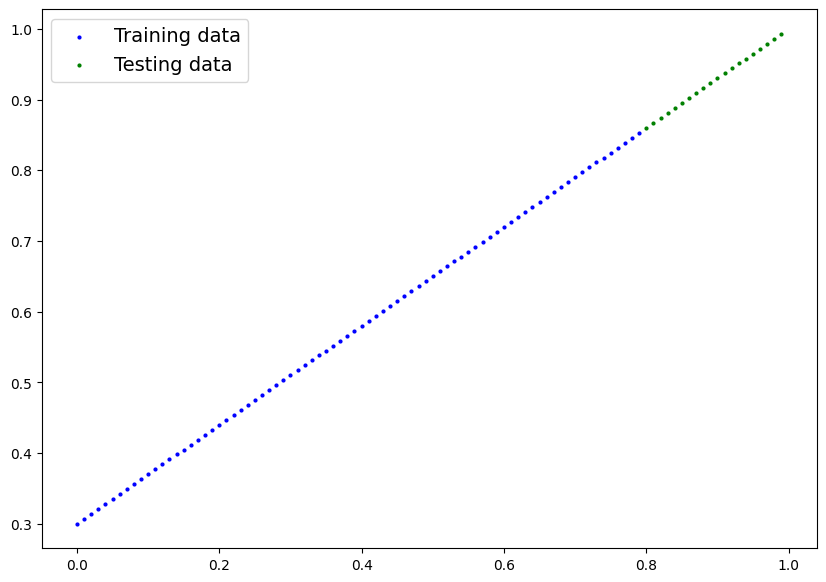

In [122]:
# Split the data into training and testing
train_split = int(0.8*len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# check the length of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

# plot train and test data
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_3` to fit the straight line data

In the regression data, we only have one feature per label, whereas `model_3` expects two features per label

One can use the `nn.sequential` for a faster syntax

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


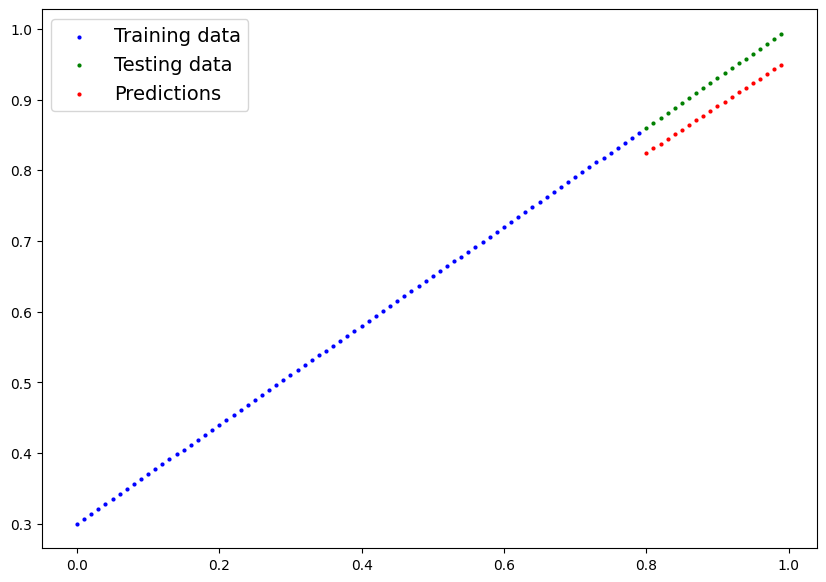

In [123]:
# redefining the model with only one feature per label
model_3_reg = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

# loss function and optimizer
loss_fn = nn.L1Loss()                           # Mean Absolute Error loss with regression data
optimizer = torch.optim.SGD(params=model_3_reg.parameters(), lr=0.01)

# prepare the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# training
for epoch in range(epochs):
    model_3_reg.train()

    # forward pass
    y_pred = model_3_reg(X_train_regression)

    # calculate the loss
    loss = loss_fn(y_pred, y_train_regression)

    # gradient descent and backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model_3_reg.eval()
    with torch.inference_mode():
        test_pred = model_3_reg(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # print results
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

# plot results
model_3_reg.eval()
with torch.inference_mode():
    y_pred = model_3_reg(X_test_regression)

# plot production uses matplotlib, which runs on the CPU
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_pred.cpu())

## 6 Non-linearity

What patterns could be draw using an infinite amount of straight and non-straight lines.

In machine learning terms: what could be achieved using a (quasi-) infinite number of linear and non-linear functions

### 6.1 Recreating non-linearit data (e.g. red and blue circles)


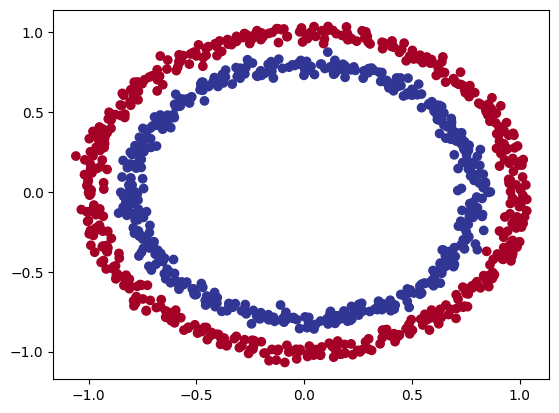

In [124]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

# convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)


### 6.2 Building a model with non-linearities

- linear = straight lines
- non-linear = non-straight lines

Every NN can be made of a combination of linear and non-linear layers and activation functions, which can be used to find patterns in data

Here is an example of one of the simplest non-linear activation functions, the Rectified Linear Unit: [`ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

![](screenshots/ReLU.png)

**Note**:
neural network architectures can be quickly simulated using the [tensorflow playground](https://playground.tensorflow.org/) app
![](./screenshots/4_tensorflow_playground.png)

Examples of applications of the next mode (binary classification)
 - email: spam or not spam 
 - credit cards: fraud or not fraud
 - insurance claims: at fault or not at fault

In [125]:
# build a model with non-linear activation functions

from torch import nn

class CircleModelV4(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()   # (non-linear activation function)
    
    def forward(self, x):
        # the non-linear activation functions should be placed in between each of the layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    

model_4 = CircleModelV4().to(device)

# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

### Training a model with non-linearities

Adding the `ReLU` activation function introduced non-linearities

In [126]:
# prepare seed and data (device agnostic)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000
for epoch in range(epochs):
    # training
    model_4.train()

    # forward pass
    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probabilities -> predictions

    # calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y=y_train, y_pred=y_pred)

    # optimizer zero gradient
    optimizer.zero_grad()

    # backward propagation
    loss.backward()

    # step the optimizer
    optimizer.step()

    # testing
    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(y=y_test, y_pred=test_pred)

    # print progress
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, loss: {loss:.4f}, acc: {acc:.2f}, test_loss: {test_loss}, test_acc: {test_acc}")

Epoch: 0, loss: 0.6929, acc: 50.00, test_loss: 0.6931881904602051, test_acc: 50.0
Epoch: 100, loss: 0.6912, acc: 52.88, test_loss: 0.6910240054130554, test_acc: 52.499996185302734
Epoch: 200, loss: 0.6898, acc: 53.38, test_loss: 0.6893961429595947, test_acc: 55.0
Epoch: 300, loss: 0.6879, acc: 53.00, test_loss: 0.6872316598892212, test_acc: 56.0
Epoch: 400, loss: 0.6852, acc: 52.75, test_loss: 0.684114933013916, test_acc: 56.5
Epoch: 500, loss: 0.6810, acc: 52.75, test_loss: 0.6794120669364929, test_acc: 56.5
Epoch: 600, loss: 0.6751, acc: 54.50, test_loss: 0.6728507876396179, test_acc: 56.0
Epoch: 700, loss: 0.6666, acc: 58.38, test_loss: 0.6632164716720581, test_acc: 58.999996185302734
Epoch: 800, loss: 0.6516, acc: 64.00, test_loss: 0.6475690603256226, test_acc: 67.5
Epoch: 900, loss: 0.6236, acc: 74.00, test_loss: 0.6214525699615479, test_acc: 79.0


### 6.4 Evaluating the model trained with non-linear activations

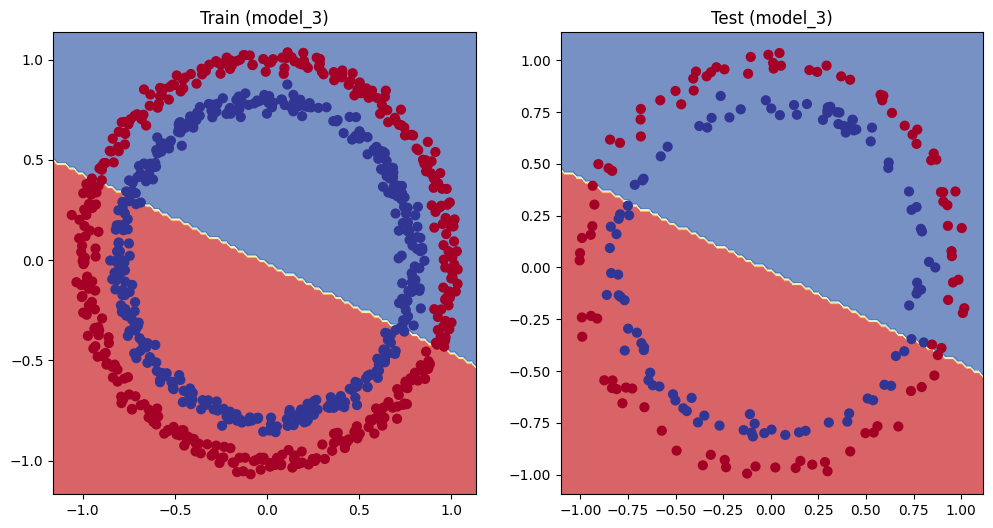

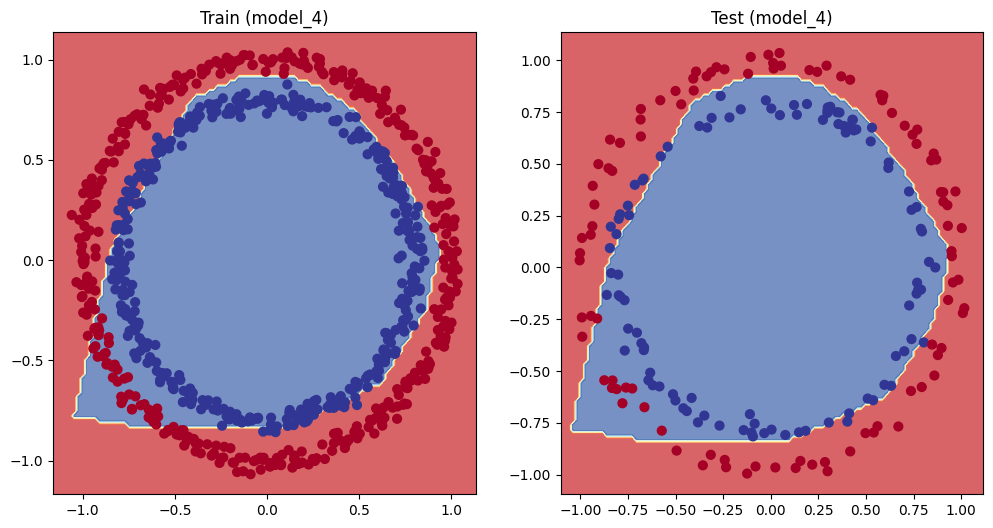

In [127]:
# make predictions
model_4.eval()
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model_4(X_test))).squeeze()

# plot decision boundaries for model 3 (linear model)
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train (model_3)")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test (model_3)")
plot_decision_boundary(model_3, X_test, y_test)

# and compare against the decision boundaries from model_4 (non-linear model)
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train (model_4)")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test (model_4)")
plot_decision_boundary(model_4, X_test, y_test)

## 7 Replication non-linear activation fcuntions

With neural networks, rather than us telling the mode what to learn, we give it the tools to discover patterns in the data, and it tries to figure those patterns out on its onw.

These tools are linear anon-linear function

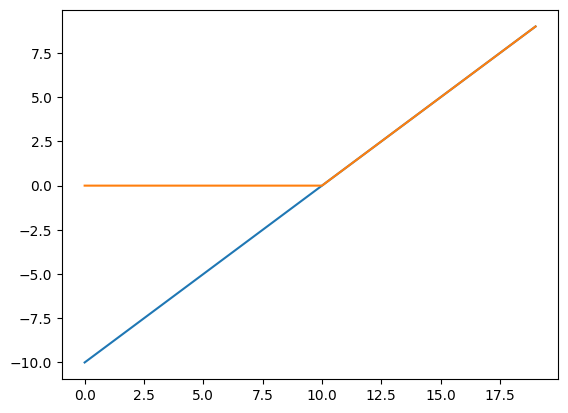

In [128]:
# creating a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)

# visualize the tensor
plt.plot(A)

# visualize the non-linear rectified linear unit
plt.plot(torch.relu(A))

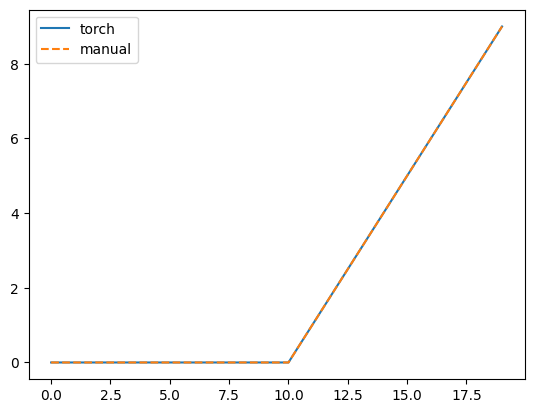

In [129]:
# replicating ReLU
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), x)    # note how inputs must be both tensors

plt.plot(torch.relu(A), label="torch")
plt.plot(relu(A), '--', label="manual")
plt.legend()

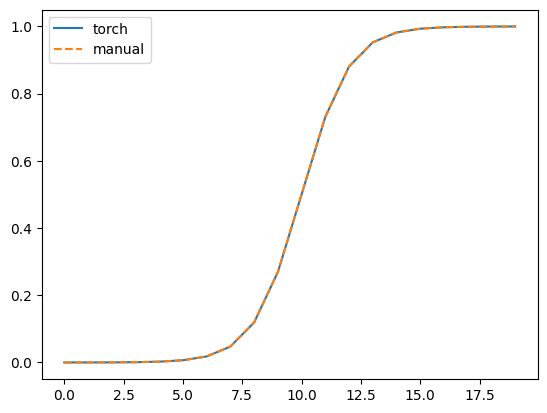

In [130]:
# we can equally implement the function for a sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1/(1 + torch.exp(-x))

plt.plot(torch.sigmoid(A), label="torch")
plt.plot(sigmoid(A), '--', label="manual")
plt.legend()

## 8. Putting it all together with a multi-class classification

 - **Binary classification**: Either one thing or another (A, or B)
 - **Multi-class classification**: more than one thing or another (A, or B, or C or ...)

![](./screenshots/5_multiclass_classification.png)

### 8.1 Creating a toy multi-class dataset

[torch.float32, torch.int64, torch.float32, torch.float32, torch.int64, torch.int64]


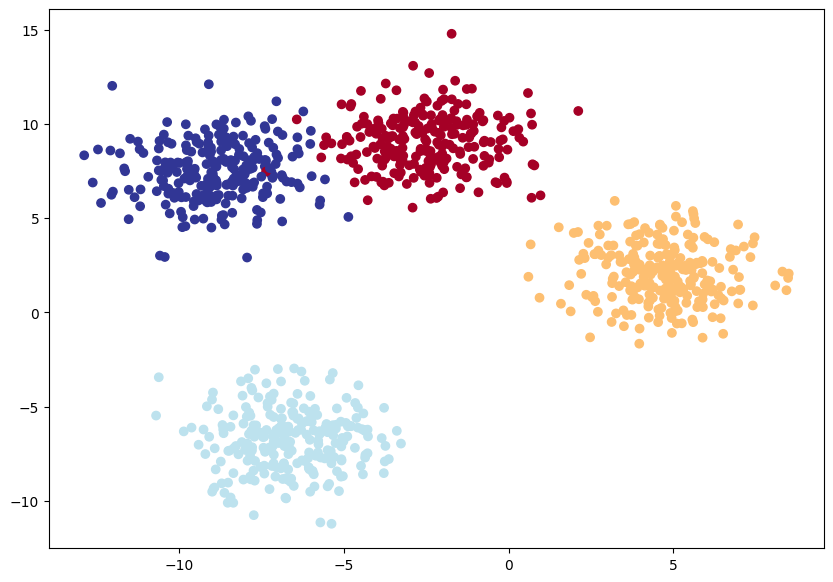

In [131]:
# import libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameters for data creation
NUM_SAMPLES = 1000
NUM_CLASSES = 4
CLUSTER_STD = 1.5
NUM_FEATURES = 2
RANDOM_SEED = 42
TEST_SIZE = 0.2
LEARNING_RATE = 0.1

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES, 
                           cluster_std=CLUSTER_STD,
                           random_state=RANDOM_SEED)

# 2. turn the data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. split into train and test data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_SEED)

print(list(map(lambda a: a.dtype, (X_blob, y_blob, X_blob_train, X_blob_test, y_blob_train, y_blob_test ))))

# 4. plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 building a multi-class classification model in PyTorch

In [146]:
# create device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, in_features:int, out_features:int, hidden_units:int=8, *args, **kwargs) -> None:
        """ Initializes multi-class classification model
        Args:
            in_features: (int): number of input features
            out_features (int): number of output features
            hidden_units (int): number of hidden units betwee layers, default 8
            
        Returns:
            BlobModel object instance
        
        Example:
            
        """
        
        super().__init__(*args, **kwargs)
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),                                                      # add non-linearity to classification boundaries
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# create an instance of BlobModel and send it to the target device
model_5 = BlobModel(in_features=2,
                    out_features=4,
                    hidden_units=8).to(device)

### 8.3 Creating a loss function and an optimizer for a multi-class classification models

In [147]:
# create a loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()   # keeping it simple for our balanced dataset

# create an optimizer for multi-class classification
optimizer = torch.optim.SGD(model_5.parameters(),
                            lr=LEARNING_RATE)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate, train and test the model, one needs to convert the model outputs (logits) to prediction probabilities to prediction labels

1. logits: raw output of the model
2. Prediction probabilities (`torch.softmax()`)
3. Prediction labels (take the maximizer argument `torch.argmax()`)

In [148]:
# printing the raw outputs of the model (logits)
X_blob_train, X_blob_test, y_blob_train, y_blob_test = map(lambda t: t.to(device), (X_blob_train, X_blob_test, y_blob_train, y_blob_test))

model_5.eval()
with torch.inference_mode():
    y_logits = model_5(X_blob_test[:10].type(torch.float))

# notice how y_test is squeezed, relative to y_logits
y_logits[:10], y_test[:10].unsqueeze(-1)

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834],
         [-0.1497, -1.0617, -0.7107, -0.1645],
         [ 0.1539, -0.2887,  0.1520, -0.0109],
         [-0.2154, -1.1795, -0.9300, -0.2745],
         [ 0.2443, -0.2472,  0.1649,  0.0061],
         [-0.2329, -1.2120, -0.9849, -0.3004]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.]]))

In [149]:
# convert the model's logits into prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

y_logits[:5], y_pred_probs[:5]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]]),
 tensor([[0.3169, 0.3244, 0.1405, 0.2182],
         [0.3336, 0.1432, 0.2026, 0.3206],
         [0.3011, 0.1843, 0.2823, 0.2323],
         [0.3078, 0.2766, 0.1836, 0.2320],
         [0.3719, 0.1286, 0.1532, 0.3463]]))

$\mathrm{Softmax}(x_i) = \dfrac{\exp{(x_i)}}{\sum_j{\exp{(x_j)}}}$

Text(0, 0.5, 'softmax(x)')

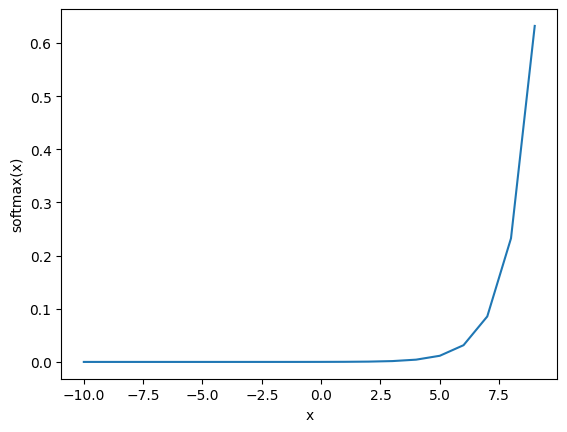

In [150]:
plt.plot(A, torch.softmax(A, dim=0))
plt.xlabel("x")
plt.ylabel("softmax(x)")

In [151]:
# conver the model's prediction probabilities into prediction labels

# y_pred_probs contains, for each datapoint, the probabilities of it corresponding to each of the existing classes
# therefore, the prediction label can be obtained simply by finding the maximizer argument (argmax)

y_preds = torch.argmax(y_pred_probs, dim=1)

# this way, y_preds natuarry becomes of the same dimensionality as y_blob_test
y_preds[:5], y_blob_test[:5]

(tensor([1, 0, 0, 0, 0]), tensor([1, 3, 2, 1, 0]))

### 8.5 Training and testing loop for a multi-class PyTorch model

In [152]:
# fit the milti-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# put the data to the target device
X_blob_train, y_blob_train, X_blob_test, y_blob_test = map(lambda a: a.to(device), (X_blob_train, y_blob_train, X_blob_test, y_blob_test))

# loop through data
for epoch in range(epochs):
    # training
    model_5.train()

    # make predictions
    y_logits = model_5(X_blob_train)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    # calculate the loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = acc_fn(y=y_blob_train, y_pred=y_pred)

    # zero gradient, backward propagation and stepping the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing the model
    model_5.eval()
    with torch.inference_mode():
        test_logits = model_5(X_blob_test)
        test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = acc_fn(y=y_blob_test, y_pred=test_pred)

    # print results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss:.4f}:, accuracy: {acc:.2f}, test loss: {test_loss:.4f}, test_accuracy: {test_acc:.2f}")


Epoch: 0, loss: 1.1588:, accuracy: 40.38, test loss: 1.0755, test_accuracy: 48.00
Epoch: 10, loss: 0.6448:, accuracy: 96.75, test loss: 0.6607, test_accuracy: 97.50
Epoch: 20, loss: 0.4254:, accuracy: 98.50, test loss: 0.4307, test_accuracy: 100.00
Epoch: 30, loss: 0.2529:, accuracy: 99.12, test loss: 0.2451, test_accuracy: 99.50
Epoch: 40, loss: 0.1123:, accuracy: 99.25, test loss: 0.1023, test_accuracy: 99.50
Epoch: 50, loss: 0.0663:, accuracy: 99.25, test loss: 0.0585, test_accuracy: 99.50
Epoch: 60, loss: 0.0507:, accuracy: 99.25, test loss: 0.0429, test_accuracy: 99.50
Epoch: 70, loss: 0.0430:, accuracy: 99.25, test loss: 0.0349, test_accuracy: 99.50
Epoch: 80, loss: 0.0384:, accuracy: 99.25, test loss: 0.0299, test_accuracy: 99.50
Epoch: 90, loss: 0.0352:, accuracy: 99.25, test loss: 0.0266, test_accuracy: 99.50


### 8.6 Making and evaluating predictions with a PyTorch multi-class mode

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]])
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


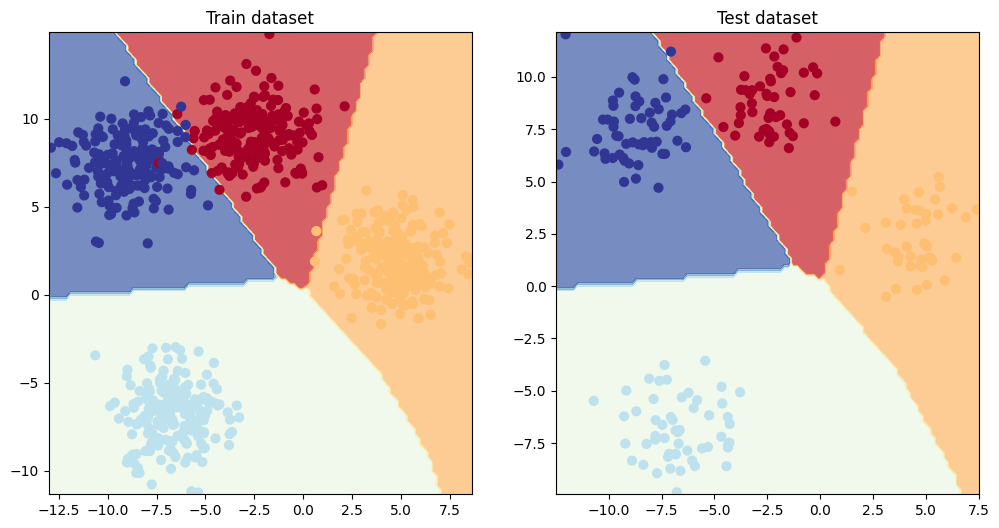

In [157]:
# make predictions
model_5.eval()
with  torch.inference_mode():
    y_logits = model_5(X_blob_test)

# converting logits into prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# view the first 10 prediction probabilities
print(y_pred_probs[:10])

# converting from probabilities to predictions
y_preds = torch.argmax(y_pred_probs,dim=1)

# view the first 10 predictions
print(y_preds[:10])

# plot results
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train dataset")
plot_decision_boundary(model_5,X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test dataset")
plot_decision_boundary(model_5,X_blob_test, y_blob_test)

# 9. A few more classification metrics (beyond than loss and accuracy)

- Accuracy: Classification success percentage
- Precision: (Imbalanced classes)
- Recall: (imbalanced classes)
- F1-score
- Confusion matrix
- Classification report

**Torchmetrics documentation**: [TorchMetrics](https://lightning.ai/docs/torchmetrics/stable/)

**Note:** Article on when to use precision and recall: ["Beyond Accuracy" by by Will Koehrsen](https://willkoehrsen.github.io/statistics/learning/beyond-accuracy-precision-and-recall/)

![](./screenshots/6_Classification_metrics.png)

In [165]:
from torchmetrics import Accuracy

# setup metrics
tm_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# calculate accuracy
tm_accuracy(y_preds, y_blob_test) # same result as what one obtains from the custom acc_fn

tensor(0.9950)

## Exercises
Exercises are solved in [02_pytorch_classification_exercises.ipynb](./02_pytorch_classification_exercises.ipynb)